In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x0000000019a40bef, Ptr{Nothing} @0x0000000019a40c13, Ptr{Nothing} @0x0000000019a26531, Ptr{Nothing} @0x0000000019a40b3a, Ptr{Nothing} @0x0000000019a40b63, Ptr{Nothing} @0x0000000019a25e98, Ptr{Nothing} @0x0000000019a40aa1, Ptr{Nothing} @0x0000000019a40ad3, Ptr{Nothing} @0x0000000019a21a8e, Ptr{Nothing} @0x0000000019a289f4, Ptr{Nothing} @0x0000000019a28d13, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001998a107, Ptr{No

In [2]:
using Plots
gr()  

Plots.GRBackend()

## unit test
### test liquid h and vapor h in a one-loop OHP heating problem-with no dynamics
### plate temperature:  constant uniform 296 K, tube initial temperature uniform 295 K 

### conduction only

# Properies

### Earth property

In [3]:
g = 9.8

9.8

### Solid Physical parameters

In [4]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [5]:
fluid_type = "butane"
Tᵥ = 295.0

295.0

In [6]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [7]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [8]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [9]:
inch = 2.54e-2;

In [10]:
power = 40 *0 #watts
total_heater_area = 2.0inch*2.0inch;

In [11]:
qe = power/total_heater_area
hc = 1500.0 * 0
Tc = Tᵥ

295.0

In [12]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [13]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 1e-2
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


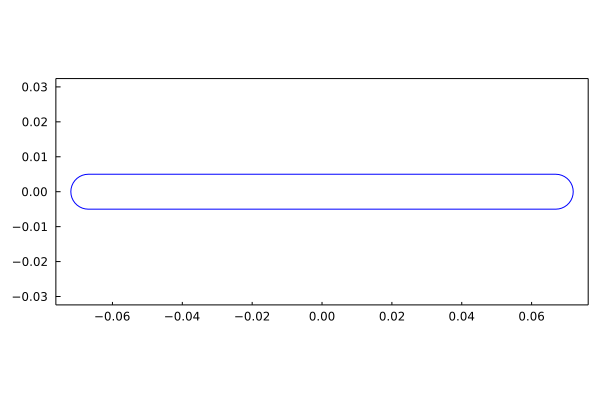

In [14]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [15]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [16]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Tube geometries

In [17]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [18]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [19]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

462.26761711088227

In [20]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(0.0,0.0+0.5L2D),(L/2,L/2+0.5L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0)) 
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)

dXdt0[2] = (1.0,1.0)

(1.0, 1.0)

In [21]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [22]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [23]:
P = 0*zeros(length(X0)) .+ TtoP.([Tᵥ,Tᵥ+1.0]);
δ = 0*zeros(length(X0)) .+ 0.1*tube_d;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

In [24]:
P

2-element Array{Float64,1}:
 220337.82769062277
 227438.93214337708

### Wall

nucleate boiling sites

In [25]:
ΔTthres = 100.0; # superheat threshold

    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [26]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [27]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [28]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [29]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [30]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [31]:
tspan = (0.0, 0.0001);
dt_record = tspan[2] /100;

tstep=1e-7

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [32]:
ΔT = 1.0 #[K]

1.0

In [33]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ + ΔT;

In [34]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [35]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [36]:
push!(plate_hist,deepcopy(integrator_plate)); 
push!(tube_hist,deepcopy(integrator_tube));

In [ ]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

1.0e-7
2.0e-7
3.0e-7
4.0e-7
5.0e-7
6.0e-7
7.0e-7
8.0e-7
9.0e-7
1.0e-6
1.1e-6
1.2e-6
1.2999999999999998e-6
1.3999999999999997e-6
1.4999999999999996e-6
1.5999999999999995e-6
1.6999999999999994e-6
1.7999999999999993e-6
1.8999999999999992e-6
1.999999999999999e-6
2.099999999999999e-6
2.199999999999999e-6
2.2999999999999987e-6
2.3999999999999986e-6
2.4999999999999985e-6
2.5999999999999984e-6
2.6999999999999983e-6
2.799999999999998e-6
2.899999999999998e-6
2.999999999999998e-6
3.099999999999998e-6
3.1999999999999977e-6
3.2999999999999976e-6
3.3999999999999975e-6
3.4999999999999974e-6
3.5999999999999973e-6
3.699999999999997e-6
3.799999999999997e-6
3.899999999999997e-6
3.999999999999997e-6
4.099999999999997e-6
4.199999999999997e-6
4.299999999999997e-6
4.399999999999997e-6
4.499999999999997e-6
4.599999999999997e-6
4.6999999999999965e-6
4.799999999999996e-6
4.899999999999996e-6
4.999999999999996e-6
5.099999999999996e-6
5.199999999999996e-6
5.299999999999996e-6
5.399999999999996e-6
5.49999999999999

In [ ]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

# plot the OHP

In [ ]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

In [ ]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T")
end

In [ ]:
q_tube_lines = sys_to_heatflux.(sysfinal);

In [ ]:
function add_qline(q_tube_lines)
    q_temp = zeros(length(q_tube_lines))
    for i = 1:length(q_tube_lines)
        q_temp[i] = sum(q_tube_lines[i] .* areas(sys.qline[1].body))
    end
    
    q_temp
end

In [ ]:
q_tube_hist = add_qline(q_tube_lines);

In [ ]:
fact = 1.0/(ρₛ*cₛ*plate_d)

In [ ]:
q_plate = []
t_hist = []
for i=1:length(plate_hist)
    dT=deepcopy(plate_hist[i].p.qline[1].cache1);
    heatconduction_rhs!(dT,temperature(plate_hist[1]),plate_hist[i].p,0.0);
    push!(q_plate, dT ./ fact)
    push!(t_hist, plate_hist[i].t)
end

In [ ]:
q_plate_hist = cellsize(sys)^2 * sum.(q_plate);

In [ ]:
plot(t_hist,q_tube_hist,linewidth=3.0,label="tube heat rate [W]")
plot!(t_hist,-q_plate_hist,ylabel="P [W]",xlabel="t [s]",markershape=:auto,label="plate heat rate [W]",legend=:topright)
# savefig("validation.pdf")

In [ ]:
norm((q_tube_hist+q_plate_hist) ./ q_tube_hist,Inf)

### Compare with analytical result at the beginning

In [ ]:
Lliquidslug = XptoLliquidslug(sys0.liquid.Xp,sys0.tube.L)

In [ ]:
Lvaporslug = XptoLvaporplug(sys0.liquid.Xp,sys0.tube.L,closedornot)

In [ ]:
Hᵥ=kₗ/δ[1]

In [ ]:
ΔT * (Hᵥ * peri * Lvaporslug[1] + Hₗ * peri * Lliquidslug[1])